In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour


In [46]:
df_delta_lags = pd.read_csv("delta_lags_12.csv")
comp01 = pd.read_csv('competencia_01.csv')

/tmp/ipykernel_4113/2839945003.py:2: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  comp01 = pd.read_csv('competencia_01.csv')


In [47]:
df_delta_lags = df_delta_lags[df_delta_lags['foto_mes'] != 202105]
comp01 = comp01[comp01['foto_mes'] != 202105]

In [48]:
comp01.shape

(814522, 155)

In [49]:
df_delta_lags.shape

(814522, 610)

In [50]:
## Mergeo con df
data = pd.merge(
    comp01,
    df_delta_lags,
    on=["numero_de_cliente", "foto_mes"],
    how="inner"
)

In [51]:
data.shape

(814522, 763)

In [52]:
ganancia_acierto = 780000
costo_estimulo = 20000

mes_train = [202101, 202102]
mes_test = 202104

# agregue sus semillas
semillas = [100343, 100103, 100109, 100129, 100057]

In [53]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [54]:
data['clase_binaria2'] = 0
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [55]:
train_data = data[data['foto_mes'].isin(mes_train)]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria2'], axis=1)
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso','clase_binaria2'], axis=1)
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

In [56]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

In [57]:
train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)

In [58]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 20, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3) # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 20, 2500)
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
 
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=4000, 
        callbacks=[
            lgb.early_stopping(stopping_rounds=int(50 + 5/learning_rate), verbose=False)],
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5

study = optuna.create_study(
    direction="maximize"
)

[I 2025-10-12 18:41:54,392] A new study created in memory with name: no-name-00bb6e7f-018f-4ced-b020-167ac268b440


In [59]:
study.optimize(objective, n_trials=30)

[I 2025-10-12 18:46:18,572] Trial 0 finished with value: 571960000.0 and parameters: {'num_leaves': 139, 'learning_rate': 0.01618996064047922, 'min_data_in_leaf': 506, 'feature_fraction': 0.7774018534238648, 'bagging_fraction': 0.6279052029322523}. Best is trial 0 with value: 571960000.0.
[I 2025-10-12 18:47:41,774] Trial 1 finished with value: 549380000.0 and parameters: {'num_leaves': 142, 'learning_rate': 0.19675034345041198, 'min_data_in_leaf': 919, 'feature_fraction': 0.4796925675751983, 'bagging_fraction': 0.6641242176927938}. Best is trial 0 with value: 571960000.0.
[I 2025-10-12 18:48:23,114] Trial 2 finished with value: 538080000.0 and parameters: {'num_leaves': 131, 'learning_rate': 0.2823778730337347, 'min_data_in_leaf': 1878, 'feature_fraction': 0.8131092101262888, 'bagging_fraction': 0.6216286949168948}. Best is trial 0 with value: 571960000.0.
[I 2025-10-12 18:50:07,443] Trial 3 finished with value: 556700000.0 and parameters: {'num_leaves': 44, 'learning_rate': 0.0981426

In [ ]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)

Mejor cantidad de árboles para el mejor model 223


In [67]:
y_pred_lgm = model.predict(X_test)

In [68]:
ganancia = np.where(y_test_class == 'BAJA+2', ganancia_acierto, 0) - np.where(y_test_class != 'BAJA+2', costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)

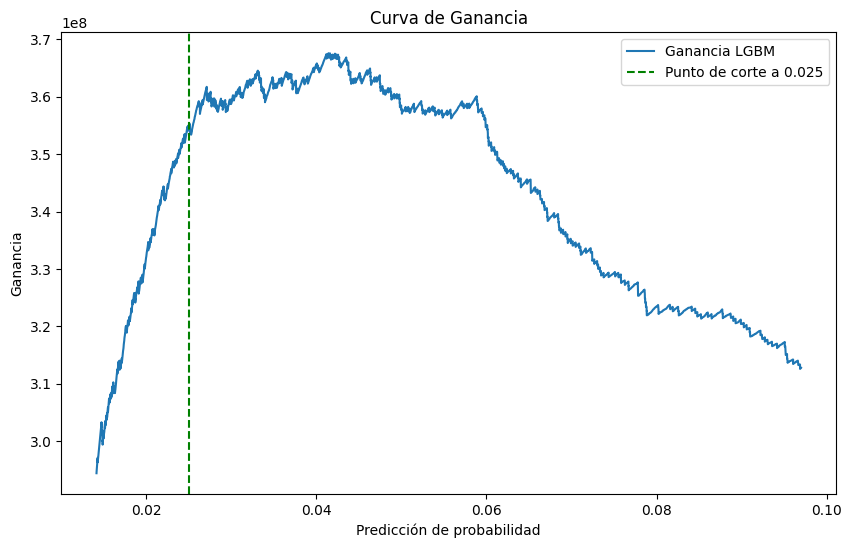

In [69]:
piso_envios = 4000
techo_envios = 20000

plt.figure(figsize=(10, 6))
plt.plot(y_pred_lgm[piso_envios:techo_envios], ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.title('Curva de Ganancia')
plt.xlabel('Predicción de probabilidad')
plt.ylabel('Ganancia')
plt.axvline(x=0.025, color='g', linestyle='--', label='Punto de corte a 0.025')
plt.legend()
plt.show()

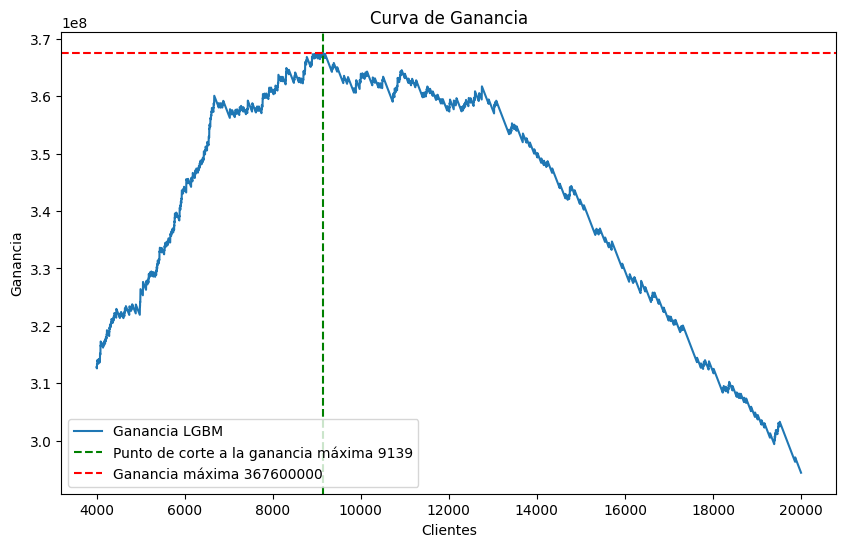

In [70]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

In [71]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 60]

,feature,importance
127,Master_fechaalta,770
11,mpasivos_margen,767
6,cliente_antiguedad,700
5,cliente_edad,661
18,mcaja_ahorro,643
...,...,...
103,catm_trx,65
95,ccallcenter_transacciones,65
402,lag_1_mpagomiscuentas,63
21,cdescubierto_preacordado,62


In [72]:
## Reentreno con train_final

TRAIN_f = [202101,202102,202103,202104]
MES_PRED  = 202106

best_iter = study.best_trial.user_attrs["best_iter"]
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_final = data[data['foto_mes'].isin(TRAIN_f)]
X_final = train_final.drop(columns=['clase_ternaria','clase_peso','clase_binaria2'])
y_final = train_final['clase_binaria2']
w_final = train_final['clase_peso']

dtrain_final = lgb.Dataset(X_final, label=y_final, weight=w_final)

model_final = lgb.train(params,
                  dtrain_final,
                  num_boost_round=best_iter)

In [73]:
k_corte = 9500

features = dtrain_final.feature_name
pred_final = data[data['foto_mes'] == MES_PRED]
X_106 = pred_final.loc[:, features]
probs_106 = model_final.predict(X_106)

order = np.argsort(probs_106)[::-1]
idx_contactar = order[:k_corte]

id_col = 'numero_de_cliente' if 'numero_de_cliente' in pred_final.columns else None
salida = pd.DataFrame({
    (id_col if id_col else 'idx'): (pred_final[id_col].values if id_col else pred_final.index.values),
    'foto_mes': pred_final['foto_mes'].values,
    'prob_predicha': probs_106,
})

rank = np.empty_like(order)
rank[order] = np.arange(1, len(order)+1)
salida['rank'] = rank

pred_bin = np.zeros(len(pred_final), dtype=int)
pred_bin[idx_contactar] = 1   # 1 para los seleccionados, 0 resto

# df submit
submit_106 = pd.DataFrame({
    'numero_de_cliente': pred_final['numero_de_cliente'].astype(int),
    'Predicted': pred_bin.astype(int)
})

# csv
submit_106.to_csv('v19_final4.csv', index=False)

## Check
print("Filas submit:", len(submit_106))
print("Distribución Predicted:\n", submit_106['Predicted'].value_counts())

Filas submit: 164313
Distribución Predicted:
 Predicted
0    154813
1      9500
Name: count, dtype: int64
